In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd
from nilmtk import STATS_CACHE

from utils.constants import DatasetType, DAY_IN_SEC
from utils.data_reading import clean_and_store_data, read_cleaned_data, \
    convert_to_nilmtk_format, store_processed_stable_periods, \
    get_full_keys_of_stable_periods, read_stable_periods
from utils.informative_index import accumulated_distance
from utils.preprocessing import generate_sync_signals, get_stable_periods, \
    interpolate_missed_data, generate_async_signals, reformat_to_accumulated
from utils.timing import time_measure
from utils.visualization import plot_sync_async_comparison

STATS_CACHE.store.close()


DS = DatasetType.IDEAL
DURATION = DAY_IN_SEC*30
MAX_GAP = 300

In [69]:
full_keys = get_full_keys_of_stable_periods(DS)
accumulated = read_stable_periods(DS, [full_keys[0]])[0]
power = read_stable_periods(DS, [full_keys[0]], power_mode=True)[0]
print('len(accumulated)', len(accumulated))
print('len(power)', len(power))

sync_signals = generate_sync_signals(accumulated, 100)
# print('len(sync_signals)', len(sync_signals))
#
async_signals = generate_async_signals(accumulated, 60000)

[reading 1 stable periods of IDEAL] finished in 0m 0.19s
[reading 1 stable periods of IDEAL] finished in 0m 0.20s
len(accumulated) 2592001
len(power) 2592000
[generating sync signals] finished in 0m 0.00s
[generating async signals] finished in 0m 0.53s


In [46]:
power[:5]

2017-03-20 14:56:06+00:00      0.0
2017-03-20 14:56:07+00:00    429.0
2017-03-20 14:56:08+00:00    444.0
2017-03-20 14:56:09+00:00    439.0
2017-03-20 14:56:10+00:00    429.0
dtype: float64

In [147]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator  # PCHIP 1-D monotonic cubic interpolation
from scipy.interpolate import CubicSpline, UnivariateSpline, InterpolatedUnivariateSpline, splrep, splev, PPoly, interp1d
from scipy.integrate import quad as integrate
from numpy.polynomial.polynomial import Polynomial

from utils.constants import MONTH_IN_SEC
from utils.preprocessing import datetime_index_to_floats
from utils.timing import time_measure
import matplotlib.pyplot as plt


def calc_squared_coefs(interpolations, i):
    p = Polynomial(interpolations.c[:, i][::-1]) / 100
    p_squared = p ** 2
    squared_coefs = p_squared.coef[::-1]
    squared_coefs = np.pad(squared_coefs, (0, 3 - len(squared_coefs)))
    return squared_coefs


def calc_squared_coefs_range(interpolations, start, end):
    with time_measure(f'calc_squared_coefs_range from {start} to {end}', is_active=False):
        return [
            calc_squared_coefs(interpolations, i)
            for i in range(start, end)
        ]



def accumulated_distance(original: pd.Series, generated: pd.Series, parallel: int = 1):
    with time_measure(f'accumulated_distance'):
        f_dates_orig = datetime_index_to_floats(original.index)
        f_dates_gen = datetime_index_to_floats(generated.index)
        united_dates = f_dates_orig.union(f_dates_gen)
        point_count = len(united_dates)
        
        print(united_dates)
        print(len(united_dates))

        lin_orig = InterpolatedUnivariateSpline(f_dates_orig, original.values, k=1)
        lin_gen = InterpolatedUnivariateSpline(f_dates_gen, generated.values, k=1)
        all_values_orig = lin_orig(united_dates)
        all_values_gen = lin_gen(united_dates)
        diff = all_values_orig - all_values_gen

        tck = splrep(united_dates, diff, k=1, s=0)
        interpolations = PPoly.from_spline(tck)
        
        print(interpolations.x / 10**2)
        print(len(interpolations.x))

        assert interpolations.c.shape[0] == 2, 'must be linear'
        assert interpolations.c.shape[1] == point_count + 1, 'interval count is wrong'



        if parallel == 1:
            squared_coefs = calc_squared_coefs_range(interpolations, 0, point_count + 1)
            squared_coefs = np.stack(squared_coefs, axis=0)
        else:
            chunk_size = point_count // parallel + 1
            arguments = [
                (interpolations, i, min(i+chunk_size, point_count+1))
                for i in range(0, point_count + 1, chunk_size)
            ]
            with Pool(parallel) as pool:
                squared_coefs_parts = pool.starmap(calc_squared_coefs_range, arguments)
            squared_coefs = np.concatenate(squared_coefs_parts, axis=0)

        squared_diffs = PPoly(squared_coefs.T, interpolations.x)

        distance = squared_diffs.integrate(united_dates[0], united_dates[-1])
        print('distance', distance)
        return distance



def power_distance(original_pow: pd.Series, generated_acc: pd.Series, parallel: int = 1):
    with time_measure(f'power_distance'):
        f_dates_orig = datetime_index_to_floats(original_pow.index)
        f_dates_gen = datetime_index_to_floats(generated_acc.index)
#         print(f_dates_orig[:5])
#         print(f_dates_gen[:5])
        united_dates = f_dates_orig.union(f_dates_gen)[1:]
        point_count = len(united_dates)

        lin_gen = InterpolatedUnivariateSpline(f_dates_gen, generated_acc.values, k=1)
        gen_der = lin_gen.derivative()
        
#         plt.plot(f_dates_gen, gen_der(f_dates_gen), 'o', label='gen_der')
        
        step_orig = interp1d(f_dates_orig, original_pow.values, 'next', fill_value='extrapolate')
        step_gen = interp1d(f_dates_gen[1:], gen_der(f_dates_gen[:-1]), 'next', fill_value='extrapolate')

        all_values_orig = step_orig(united_dates)
        all_values_gen = step_gen(united_dates)
#         print(all_values_orig[:5])
#         print(all_values_gen[:5])
        diff = all_values_orig - all_values_gen
    
        print('all_values_orig', all_values_orig) #########

        
#         for i in range(len(united_dates)-1):
#             interval = np.linspace(united_dates[i], united_dates[i+1], 10)
#         for i in range(len(gen_der.get_knots())-1):
#             interval = np.linspace(gen_der.get_knots()[i], gen_der.get_knots()[i+1], 10)
#             plt.plot(interval, gen_der(interval), ':', label='der')
# #             plt.plot(f_dates_gen, gen_der(f_dates_gen), 'o', label='raw')
#             plt.plot(interval, step_gen(interval), '--', label='step_gen')
            
# #             interval = np.linspace(f_dates_orig[i], f_dates_orig[i+1], 10)
#             plt.plot(interval, step_orig(interval), ':', label='step_orig')
            
#         interval = np.linspace(united_dates[0], united_dates[-1], point_count*4)
#         interval = np.linspace(f_dates_gen[0], f_dates_gen[-1], point_count*3)
#         plt.plot(interval, lin_gen(interval), ':', label='lin_gen')
#         plt.plot(f_dates_gen, lin_gen(f_dates_gen), 'x', label='lin_gen')
#         plt.plot(interval, gen_der(interval), ':', label='der')
#         plt.plot(interval, step_gen(interval), '--', label='step_gen')
#         plt.plot(interval, step_gen(interval), '--', label='step_gen')
#         plt.plot(interval, step_orig(interval), ':', label='step_orig')


#         plt.plot(united_dates, diff, '-', label='diff')
#         plt.plot(f_dates_orig, original_pow.values, 'o', label='raw')
        
#         plt.plot(f_dates_orig, original.values, 'x', label='orig')
#         plt.plot(f_dates_gen, generated_acc.values, 'o', label='gen')
        plt.plot(united_dates, all_values_orig, '--', label='orig_lin')
        plt.plot(united_dates, all_values_gen, ':', label='gen_lin')
        
        plt.plot(united_dates, diff, ':', label='diff')
#         plt.plot(united_dates, ppoly(united_dates), 'x:', label='ppoly')
        plt.legend(loc = 'best')
        plt.show()



all_values_orig [  0. 429. 444. ... 210. 225. 226.]


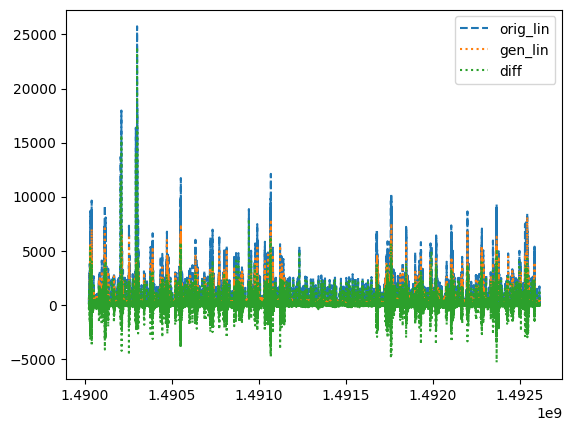

[power_distance] finished in 0m 5.76s


In [148]:
# power_distance(power[:2800], async_signals[:28])
# power_distance(power[:5000], sync_signals[:50])
power_distance(power, sync_signals)

In [145]:
accumulated_distance(power[:10], async_signals[:5])

Index([      1490021765.0,       1490021766.0,       1490021767.0,
             1490021768.0,       1490021769.0,       1490021770.0,
             1490021771.0,       1490021772.0,       1490021773.0,
             1490021774.0,       1490021775.0, 1490021901.3889127,
       1490022020.4705758, 1490022116.9005036,  1490022209.790375],
      dtype='float64')
15
[14900217.65       14900217.65       14900217.66       14900217.67
 14900217.68       14900217.69       14900217.7        14900217.71
 14900217.72       14900217.73       14900217.74       14900217.75
 14900219.01388913 14900220.20470576 14900221.16900504 14900222.09790375
 14900222.09790375]
17
distance 674543449.9861355
[accumulated_distance] finished in 0m 0.01s


array(6.7454345e+08)